# Entraînement de modèles pour la détection de pneumonie (scikit-learn avec PCA)

Ce notebook présente l'implémentation et l'entraînement de différents modèles pour la détection de pneumonie à partir de radiographies thoraciques, en utilisant scikit-learn avec réduction de dimensionnalité PCA.

Nous suivrons une approche progressive :
1. Préparation des données avec la bonne répartition train/validation (75%/25%)
2. Réduction de dimensionnalité avec PCA
3. Implémentation de modèles classiques (régression logistique, arbre de décision, random forest, SVM)
4. Évaluation des performances
5. Optimisation des hyperparamètres

In [13]:
# Ajouter le répertoire parent au chemin de recherche Python
import sys
import os

# Obtenir le chemin absolu du répertoire parent
notebook_dir = os.path.abspath('')
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [14]:
# Imports standard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# Imports scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Imports depuis notre projet
from src.preprocessing import preprocess_images as preproc
from src.visualization import visualizer as viz

# Configuration pour afficher les images dans le notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use('ggplot')

## 1. Préparation des données

Nous allons utiliser notre module de prétraitement pour préparer les données avec une répartition train/validation de 75%/25%.

In [15]:
# Définir les chemins vers les données
data_dir = '../data/chest_Xray'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Définir la taille des images
img_size = (150, 150)

In [16]:
# Préparer les données avec notre module de prétraitement
X_train, y_train, X_val, y_val, X_test, y_test = preproc.preparer_donnees_pour_modele(
    train_dir, test_dir, img_size=img_size, validation_size=0.25
)

Données d'entraînement chargées: 5216 images
  - Images normales: 1341
  - Images avec pneumonie: 3875

Répartition après division:
Ensemble d'entraînement: 3912 images
  - Images normales: 1006
  - Images avec pneumonie: 2906
Ensemble de validation: 1304 images
  - Images normales: 335
  - Images avec pneumonie: 969

Ensemble de test: 624 images
  - Images normales: 234
  - Images avec pneumonie: 390


## 2. Redimensionner les données pour les modèles classiques

Les modèles classiques de scikit-learn attendent des données sous forme de vecteurs 1D, pas des images 2D/3D. Nous devons donc redimensionner nos données.

In [17]:
# Redimensionner les données pour les modèles classiques
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

# Calculer le nombre de caractéristiques
n_features = np.prod(X_train.shape[1:])

# Redimensionner les données
X_train_reshaped = X_train.reshape(n_train, n_features)
X_val_reshaped = X_val.reshape(n_val, n_features)
X_test_reshaped = X_test.reshape(n_test, n_features)

print(f"Forme des données redimensionnées pour les modèles classiques:")
print(f"X_train: {X_train_reshaped.shape}")
print(f"X_val: {X_val_reshaped.shape}")
print(f"X_test: {X_test_reshaped.shape}")

Forme des données redimensionnées pour les modèles classiques:
X_train: (3912, 22500)
X_val: (1304, 22500)
X_test: (624, 22500)


## 3. Réduction de dimensionnalité avec PCA

Nous allons maintenant appliquer l'Analyse en Composantes Principales (PCA) pour réduire la dimensionnalité des données. Cela permettra d'accélérer considérablement l'entraînement des modèles, en particulier pour le SVM qui est très lent avec des données de haute dimension.

In [18]:
# Application de PCA pour réduire la dimensionnalité
print("Application de PCA pour réduire la dimensionnalité...")
n_components = 100  # Nombre de composantes à conserver
pca = PCA(n_components=n_components)

# Ajustement de PCA sur les données d'entraînement et transformation
X_train_pca = pca.fit_transform(X_train_reshaped)

# Transformation des données de validation et de test
X_val_pca = pca.transform(X_val_reshaped)
X_test_pca = pca.transform(X_test_reshaped)

# Affichage des nouvelles dimensions
print(f"Forme des données après réduction PCA:")
print(f"X_train_pca: {X_train_pca.shape}")
print(f"X_val_pca: {X_val_pca.shape}")
print(f"X_test_pca: {X_test_pca.shape}")

Application de PCA pour réduire la dimensionnalité...
Forme des données après réduction PCA:
X_train_pca: (3912, 100)
X_val_pca: (1304, 100)
X_test_pca: (624, 100)


Variance expliquée par les 100 composantes: 0.8843 (ou 88.43%)


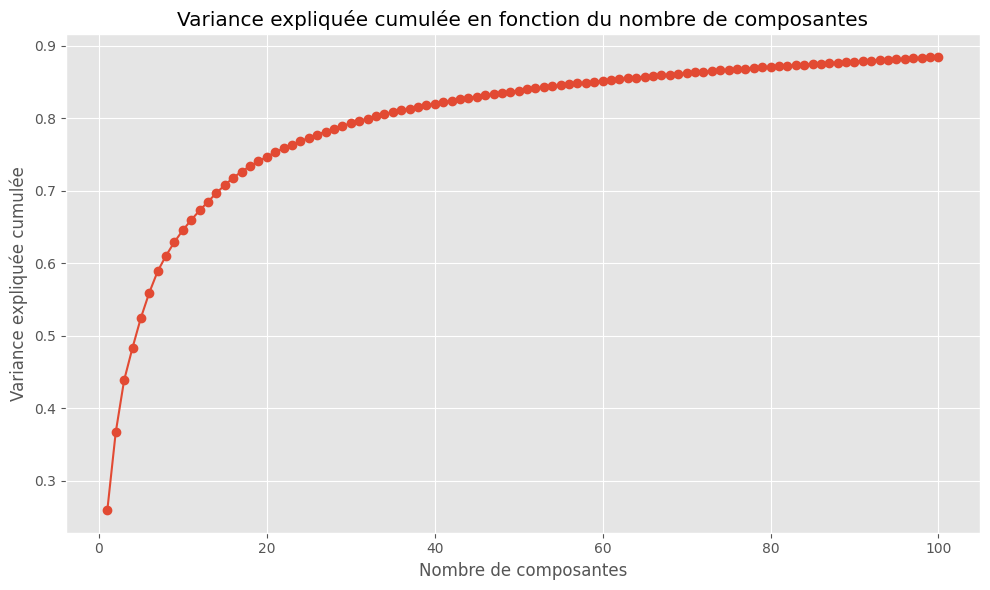

In [19]:
# Calcul du pourcentage de variance expliquée
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)
print(f"Variance expliquée par les {n_components} composantes: {cumulative_variance[-1]:.4f} (ou {cumulative_variance[-1]*100:.2f}%)")

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée en fonction du nombre de composantes')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Fonction pour évaluer les modèles

Nous allons définir une fonction pour évaluer les performances des modèles.

In [20]:
def afficher_metriques(y_true, y_pred, nom_modele, modele=None, X_test=None):
    """Affiche les métriques d'évaluation pour un modèle."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Métriques pour {nom_modele}:")
    print(f"Exactitude (Accuracy): {accuracy:.4f}")
    print(f"Précision (Precision): {precision:.4f}")
    print(f"Rappel (Recall): {recall:.4f}")
    print(f"Score F1: {f1:.4f}")
    print("\nRapport de classification détaillé:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonie']))
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonie'],
                yticklabels=['Normal', 'Pneumonie'])
    plt.title(f'Matrice de confusion - {nom_modele}')
    plt.ylabel('Vérité terrain')
    plt.xlabel('Prédiction')
    plt.tight_layout()
    plt.show()
    
    # Courbe ROC si le modèle peut prédire des probabilités
    if modele is not None and X_test is not None:
        try:
            y_proba = modele.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Taux de faux positifs')
            plt.ylabel('Taux de vrais positifs')
            plt.title(f'Courbe ROC - {nom_modele}')
            plt.legend(loc="lower right")
            plt.show()
        except:
            print("Impossible d'afficher la courbe ROC pour ce modèle.")
    else:
        print("Impossible d'afficher la courbe ROC pour ce modèle.")

In [21]:
def entrainer_et_evaluer_modele(modele, X_train, y_train, X_val, y_val, nom_modele):
    """Entraîne un modèle et évalue ses performances."""
    # Mesurer le temps d'entraînement
    debut_entrainement = time.time()
    modele.fit(X_train, y_train)
    fin_entrainement = time.time()
    temps_entrainement = fin_entrainement - debut_entrainement
    
    # Mesurer le temps de prédiction
    debut_prediction = time.time()
    y_pred = modele.predict(X_val)
    fin_prediction = time.time()
    temps_prediction = fin_prediction - debut_prediction
    
    # Afficher les métriques
    print(f"\n{'='*50}")
    print(f"Résultats pour {nom_modele}")
    print(f"{'='*50}")
    print(f"Temps d'entraînement: {temps_entrainement:.2f} secondes")
    print(f"Temps de prédiction: {temps_prediction:.2f} secondes")
    
    afficher_metriques(y_val, y_pred, nom_modele, modele, X_val)
    
    return modele, temps_entrainement, temps_prediction

In [22]:
def optimiser_hyperparametres(X_train, y_train, X_val, y_val, modele_base, nom_modele, param_grid):
    """Optimise les hyperparamètres d'un modèle en utilisant GridSearchCV."""
    print(f"\nOptimisation des hyperparamètres pour {nom_modele}...")
    
    # Utiliser 3 plis au lieu de 5 pour accélérer l'optimisation
    grid_search = GridSearchCV(
        estimator=modele_base,
        param_grid=param_grid,
        cv=3,  # Réduire le nombre de plis pour accélérer
        scoring='accuracy',
        n_jobs=2  # Utiliser plusieurs cœurs pour paralléliser
    )
    
    # Entraîner le modèle sur les données d'entraînement
    grid_search.fit(X_train, y_train)
    
    # Obtenir le meilleur modèle et ses paramètres
    meilleur_modele = grid_search.best_estimator_
    meilleurs_params = grid_search.best_params_
    
    # Évaluer le modèle sur les données de validation
    y_pred = meilleur_modele.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Meilleurs paramètres pour {nom_modele}: {meilleurs_params}")
    print(f"Exactitude sur l'ensemble de validation: {accuracy:.4f}")
    
    return meilleur_modele

## 5. Entraînement des modèles classiques

Nous allons entraîner plusieurs modèles classiques et comparer leurs performances.

In [23]:
# Liste des modèles à entraîner
modeles = [
    {
        'nom': 'Régression Logistique',
        'modele': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'saga']
        }
    },
    {
        'nom': 'Arbre de Décision',
        'modele': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'nom': 'Random Forest',
        'modele': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    {
        'nom': 'SVM',
        'modele': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
]


Entraînement du modèle: Régression Logistique

Optimisation des hyperparamètres pour Régression Logistique...
Meilleurs paramètres pour Régression Logistique: {'C': 0.1, 'solver': 'saga'}
Exactitude sur l'ensemble de validation: 0.9594

Résultats pour Régression Logistique
Temps d'entraînement: 2.14 secondes
Temps de prédiction: 0.00 secondes
Métriques pour Régression Logistique:
Exactitude (Accuracy): 0.9594
Précision (Precision): 0.9781
Rappel (Recall): 0.9670
Score F1: 0.9725

Rapport de classification détaillé:
              precision    recall  f1-score   support

      Normal       0.91      0.94      0.92       335
   Pneumonie       0.98      0.97      0.97       969

    accuracy                           0.96      1304
   macro avg       0.94      0.95      0.95      1304
weighted avg       0.96      0.96      0.96      1304



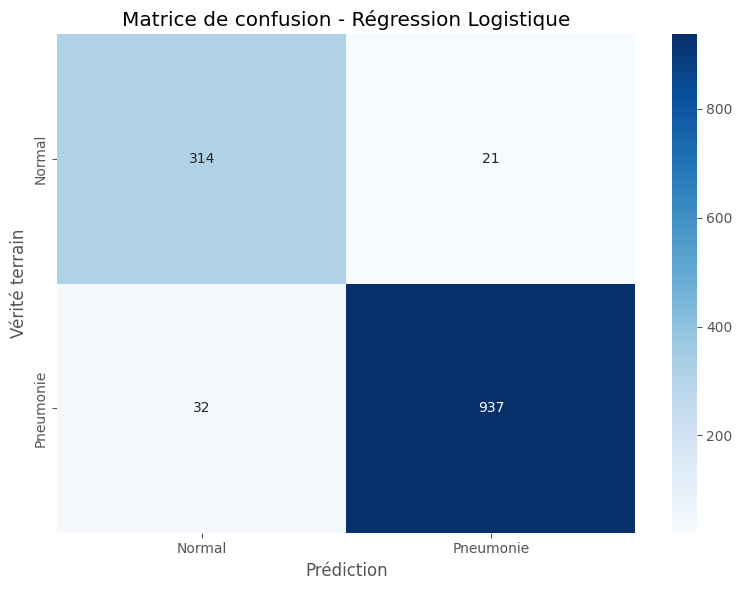

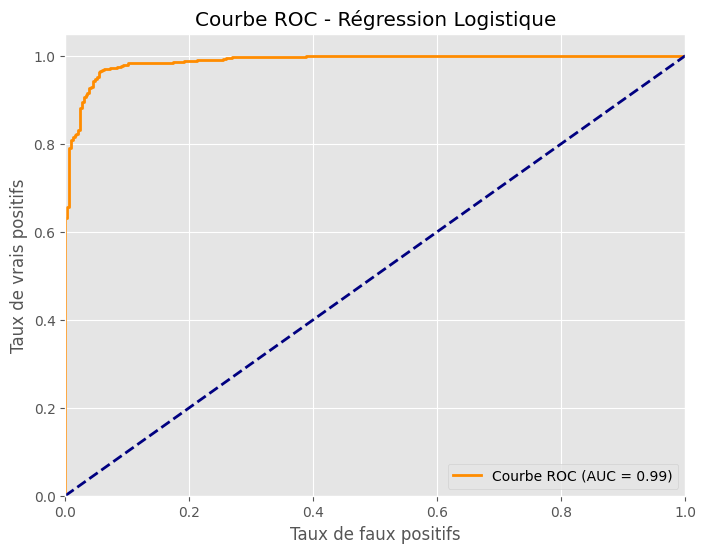

Modèle Régression Logistique sauvegardé dans ../models/régression_logistique_model.pkl

Entraînement du modèle: Arbre de Décision

Optimisation des hyperparamètres pour Arbre de Décision...
Meilleurs paramètres pour Arbre de Décision: {'max_depth': 10, 'min_samples_split': 2}
Exactitude sur l'ensemble de validation: 0.8804

Résultats pour Arbre de Décision
Temps d'entraînement: 0.94 secondes
Temps de prédiction: 0.00 secondes
Métriques pour Arbre de Décision:
Exactitude (Accuracy): 0.8804
Précision (Precision): 0.9248
Rappel (Recall): 0.9133
Score F1: 0.9190

Rapport de classification détaillé:
              precision    recall  f1-score   support

      Normal       0.76      0.79      0.77       335
   Pneumonie       0.92      0.91      0.92       969

    accuracy                           0.88      1304
   macro avg       0.84      0.85      0.85      1304
weighted avg       0.88      0.88      0.88      1304



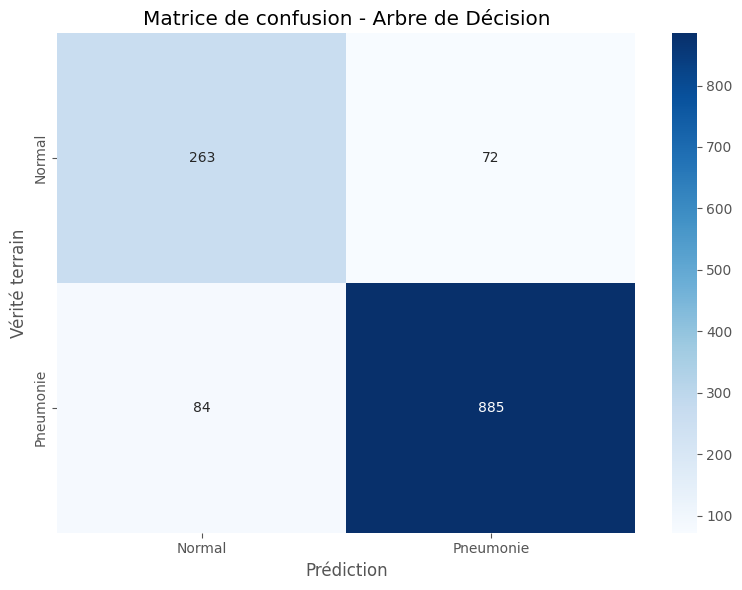

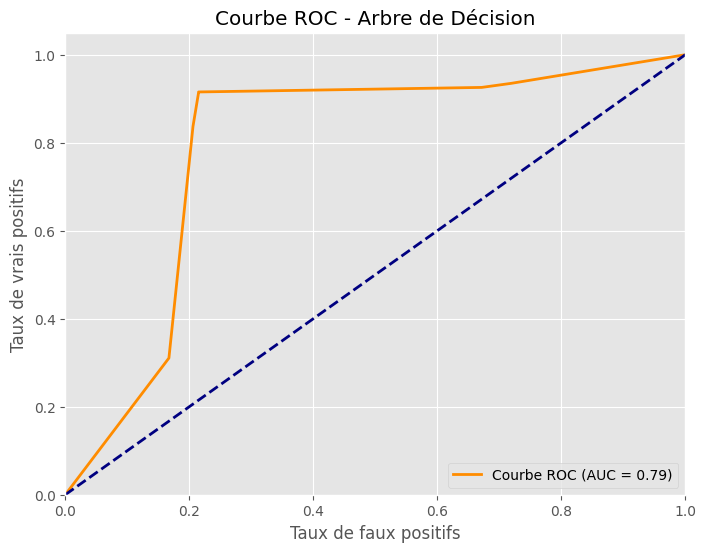

Modèle Arbre de Décision sauvegardé dans ../models/arbre_de_décision_model.pkl

Entraînement du modèle: Random Forest

Optimisation des hyperparamètres pour Random Forest...
Meilleurs paramètres pour Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Exactitude sur l'ensemble de validation: 0.9333

Résultats pour Random Forest
Temps d'entraînement: 9.18 secondes
Temps de prédiction: 0.04 secondes
Métriques pour Random Forest:
Exactitude (Accuracy): 0.9333
Précision (Precision): 0.9249
Rappel (Recall): 0.9907
Score F1: 0.9567

Rapport de classification détaillé:
              precision    recall  f1-score   support

      Normal       0.97      0.77      0.86       335
   Pneumonie       0.92      0.99      0.96       969

    accuracy                           0.93      1304
   macro avg       0.95      0.88      0.91      1304
weighted avg       0.94      0.93      0.93      1304



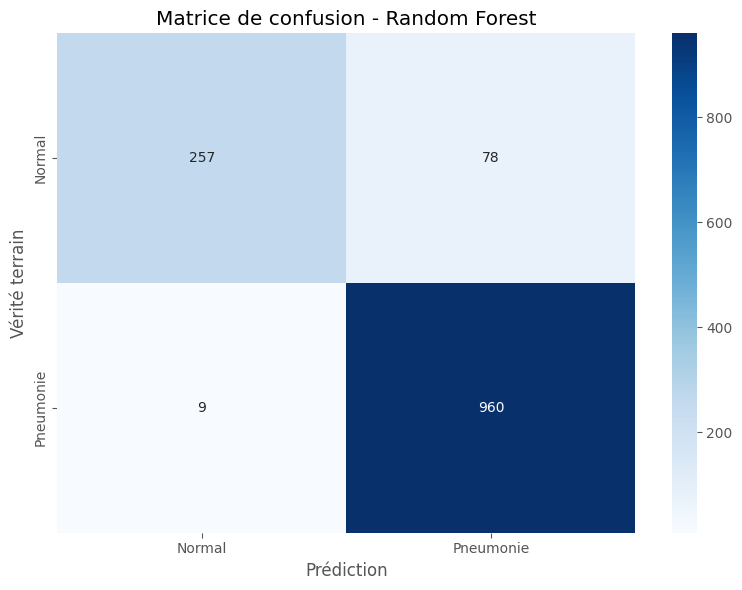

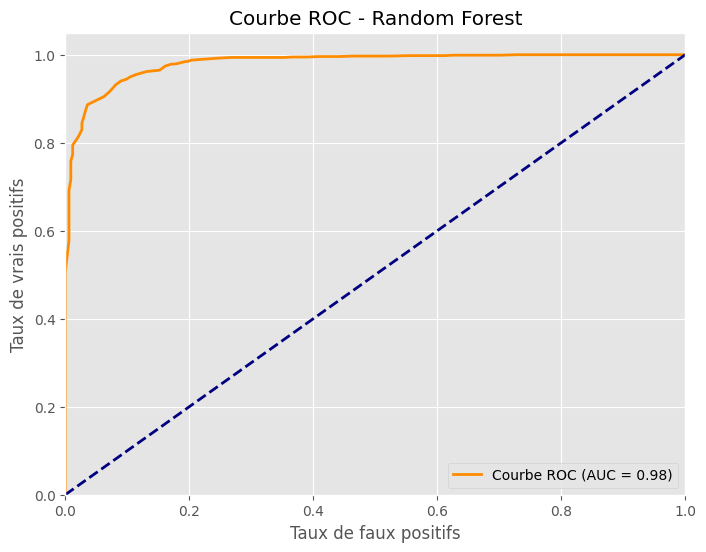

Modèle Random Forest sauvegardé dans ../models/random_forest_model.pkl

Entraînement du modèle: SVM

Optimisation des hyperparamètres pour SVM...
Meilleurs paramètres pour SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Exactitude sur l'ensemble de validation: 0.9663

Résultats pour SVM
Temps d'entraînement: 0.94 secondes
Temps de prédiction: 0.08 secondes
Métriques pour SVM:
Exactitude (Accuracy): 0.9663
Précision (Precision): 0.9763
Rappel (Recall): 0.9783
Score F1: 0.9773

Rapport de classification détaillé:
              precision    recall  f1-score   support

      Normal       0.94      0.93      0.93       335
   Pneumonie       0.98      0.98      0.98       969

    accuracy                           0.97      1304
   macro avg       0.96      0.95      0.96      1304
weighted avg       0.97      0.97      0.97      1304



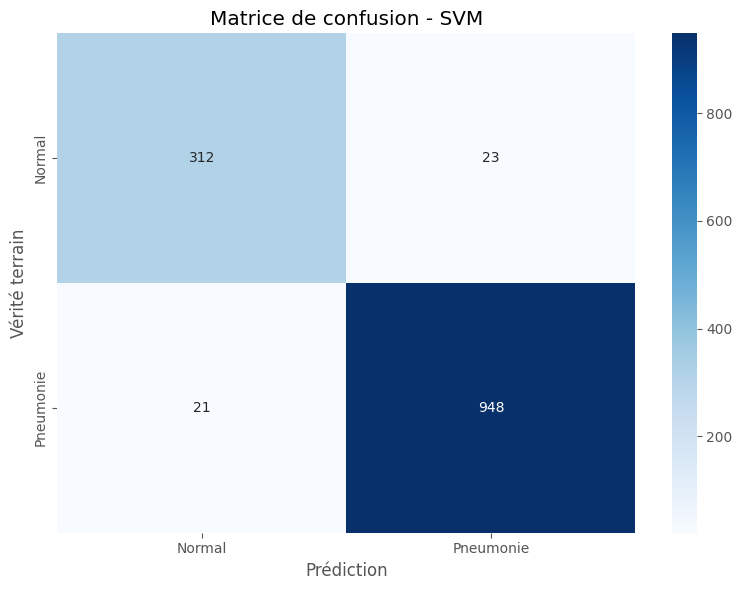

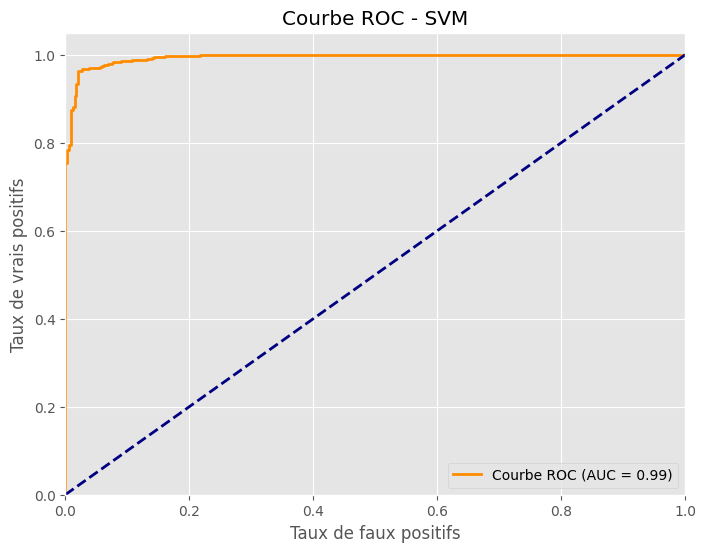

Modèle SVM sauvegardé dans ../models/svm_model.pkl


In [24]:
# Entraînement et évaluation des modèles
resultats = []

for modele_info in modeles:
    print(f"\nEntraînement du modèle: {modele_info['nom']}")
    
    # Optimiser les hyperparamètres
    modele_optimise = optimiser_hyperparametres(
        X_train_pca, y_train,  # Utiliser les données PCA
        X_val_pca, y_val,      # Utiliser les données PCA
        modele_info['modele'],
        modele_info['nom'],
        modele_info['params']
    )
    
    # Entraîner et évaluer le modèle
    modele, temps_entrainement, temps_prediction = entrainer_et_evaluer_modele(
        modele_optimise,
        X_train_pca, y_train,  # Utiliser les données PCA
        X_val_pca, y_val,      # Utiliser les données PCA
        modele_info['nom']
    )
    
    # Stocker les résultats
    resultats.append({
        'nom': modele_info['nom'],
        'modele': modele,
        'temps_entrainement': temps_entrainement,
        'temps_prediction': temps_prediction
    })
    
    # Sauvegarder le modèle
    joblib.dump(modele, f'../models/{modele_info["nom"].lower().replace(" ", "_")}_model.pkl')
    print(f"Modèle {modele_info['nom']} sauvegardé dans ../models/{modele_info['nom'].lower().replace(' ', '_')}_model.pkl")

In [25]:
# Sauvegarde du modèle PCA pour une utilisation ultérieure
joblib.dump(pca, '../models/pca_model.pkl')
print("Modèle PCA sauvegardé dans ../models/pca_model.pkl")

Modèle PCA sauvegardé dans ../models/pca_model.pkl


## 6. Comparaison des performances des modèles

Nous allons maintenant comparer les performances des différents modèles.

In [26]:
# Comparaison des performances des modèles
print("\nComparaison des performances des modèles:")
for resultat in resultats:
    print(f"{resultat['nom']}:")
    print(f"  - Temps d'entraînement: {resultat['temps_entrainement']:.2f} secondes")
    print(f"  - Temps de prédiction: {resultat['temps_prediction']:.2f} secondes")


Comparaison des performances des modèles:
Régression Logistique:
  - Temps d'entraînement: 2.14 secondes
  - Temps de prédiction: 0.00 secondes
Arbre de Décision:
  - Temps d'entraînement: 0.94 secondes
  - Temps de prédiction: 0.00 secondes
Random Forest:
  - Temps d'entraînement: 9.18 secondes
  - Temps de prédiction: 0.04 secondes
SVM:
  - Temps d'entraînement: 0.94 secondes
  - Temps de prédiction: 0.08 secondes


## 7. Conclusion

Dans ce notebook, nous avons :
1. Préparé les données pour l'entraînement des modèles
2. Appliqué la réduction de dimensionnalité avec PCA pour réduire les caractéristiques de 22 500 à 100
3. Entraîné et optimisé plusieurs modèles classiques (régression logistique, arbre de décision, random forest, SVM)
4. Évalué et comparé les performances des modèles

L'utilisation de PCA a permis d'accélérer considérablement l'entraînement des modèles, en particulier pour le SVM qui est très sensible à la dimensionnalité des données. Cela a également permis de réduire le risque de surapprentissage en éliminant les caractéristiques redondantes ou non pertinentes.